## Reinforcement learning test task

Есть replay memory - память с эпизодами игры, вместимость N

$Q(s, a, \theta)$ инициализируем случайными весами $\theta$

По эпизодам от 1 до $M$:

По шагам внути эпизода от 1 до T:

с вероятностью $\varepsilon$ делаем случайное действие $a_t$

иначе берем $a_t = \max_a Q^*(s_t, a, \theta)$

Запускаем действие в эмуляторе игры и получаем $(s_t, a_t, r_t, s_{t+1})$ -> сохраняем в replay memory


Берем мини-батч из replay memory

устанавливаем $y_j$

Если состояние терминальное, то $y_j = r_j$ - реворд

Иначе $y_j = r_j + \gamma \max_{a'} Q(s_{j+1}, a', \theta)$ - вычисляем на основе прошлой версии 

Делаем шаг градиентного спуска, минимизируем $(y_j - Q(s_j, a_j, \theta))^2$

In [1]:
import torch
from torch import nn, optim
import copy
import random
import gym

device = torch.device('cuda')

In [2]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def append(self, elem):
        if len(self.memory) < self.capacity:
            self.memory.append(elem)
        self.memory[self.position] = elem
        self.position = (self.position + 1) % self.capacity
            
    def get_minibatch(self, size):
        return random.sample(self.memory, size)
    
    def clear(self):
        self.memory = []
        self.position = 0
    
    def __len__(self):
        return len(self.memory)

In [3]:
# epsilon-greedy policy
def select_action(epsilon, state, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
    return model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()

In [4]:
# define constants

batch_size = 128

max_step = 100001
update_step = 1000

max_eps = 0.5
min_eps = 0.1

memory_capacity = 5000

gamma = 0.99

In [5]:
def gradient_descent_step(batch):
    state, action, reward, next_state, is_terminal = batch
    
    state = torch.tensor(state).to(device).float()
    action = torch.tensor(action).to(device)
    reward = torch.tensor(reward).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    
    target_q = torch.zeros(reward.size()[0]).float().to(device)
    with torch.no_grad():
        target_q[is_terminal] = target_model(next_state).max(1)[0].detach()[is_terminal]
    target_q = reward + target_q * gamma
        
    q = model(state).gather(1, action.unsqueeze(1))
    
    loss = nn.functional.smooth_l1_loss(q, target_q.unsqueeze(1))
    
    optimizer.zero_grad()
    
    loss.backward()
    
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()

In [6]:
def exploit(model, render = True):
    state = env.reset()
    r = 0.
    is_terminal = False
    
    while not is_terminal:
        eps = 0.
        if render:
            env.render()
        action = select_action(eps, state, model)
        state, reward, is_terminal, _ = env.step(action)
        r += reward
    return r

In [7]:
def train(model, target_model, optimizer):
    reward_history = []
    replay_memory = Memory(memory_capacity)
    
    state = env.reset()
    
    max_step = 100001
    
    for step in range(1, max_step):
        # select action with probability eps
        eps = max_eps - (max_eps - min_eps) * step / max_step 
        action = select_action(eps, state, model)

        # execute action in emulator and update state + reward
        new_state, reward, is_terminal, _= env.step(action)

        
        # store info in replay memory
        
        if is_terminal:
            replay_memory.append((state, action, reward, 
                                  new_state, is_terminal))
            state = env.reset()
            is_terminal = False
        else:
            replay_memory.append((state, action, reward + 5 * abs(new_state[1]), 
                              new_state, is_terminal))
            state = new_state
        
        # make stochastic gradient descent step
        # sample random minibatch from replay memory
        if step > batch_size:
            gradient_descent_step(list(zip(*replay_memory.get_minibatch(batch_size))))
            
            
        if step % update_step == 0:
            target_model = copy.deepcopy(model)
            r = exploit(target_model, True)
            reward_history.append(r)
            
    return reward_history

In [8]:
# create environment
env = gym.make('MountainCar-v0')

# create model + optimizer
model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 3))

target_model = copy.deepcopy(model)

def init_model_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
        
model.apply(init_model_weights)

model.to(device)
target_model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 3e-5)

In [9]:
rewards = train(model, target_model, optimizer)

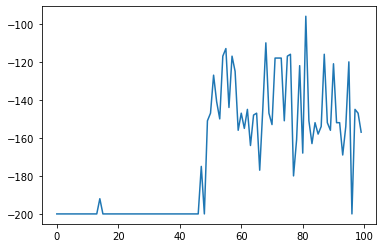

In [11]:
import matplotlib.pyplot as plt

plt.plot(rewards)